In [192]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from sklearn import preprocessing
import GPy
import itertools
%matplotlib inline
import math
from sklearn.datasets import fetch_mldata
from pandas.tools.plotting import autocorrelation_plot

In [294]:
import quandl
yhoo = quandl.get("EOD/AABA", authtoken="")

In [295]:
#Given features and targets make an augmented structure

#make a flat augmented structure, this time
max_delta = 30

#adapt the functional augmented to just do augmented, ie set year =1
years = 1
days = yhoo.shape[0]
n=list(range(0,years))
ob=list(range(0,days))
c = list(itertools.product(n, ob))
tar=list(range(0,days))
combo = list(itertools.product(c,tar))
flat_combo = [[elem[0][0],elem[0][1],elem[1]] for elem in combo]

aug_raw_data = pd.DataFrame(flat_combo, columns=['Year', 'Ob_day', 'Tar_day',])
aug_raw_data['Delta']= aug_raw_data['Tar_day'] - aug_raw_data['Ob_day']

#do the features - messy way but have adapted from func-aug
#now put in the features
ob_pd = yhoo.shift(1)
features = ob_pd[['Adj_Close','Volume']]
features = features.values
features[0]=0

oprices = np.tile(features[:,0].reshape(years,days),days).reshape((-1,))
aug_raw_data['OPrices'] = oprices.reshape(days,days).T.flatten()

ovols = np.tile(features[:,1].reshape(years,days),days).reshape((-1,))
aug_raw_data['OVols'] = ovols.reshape(days,days).T.flatten()

prices = yhoo.Adj_Close

#do the targets
aug_raw_data['TPrices'] = np.tile(prices.reshape(years,days),days).reshape((-1,))

aug_raw_data = aug_raw_data[(aug_raw_data["Delta"] >= 0) & (aug_raw_data["Delta"] < max_delta)]
aug_raw_data = aug_raw_data.reset_index(drop=True)
aug_raw_data.drop('Year', axis=1, inplace=True)
aug_raw_data.drop('Tar_day', axis=1, inplace=True)

 /Users/johngoodacre/anaconda/envs/gp/lib/python3.6/site-packages/ipykernel_launcher.py:35: FutureWarning:reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


In [296]:
aug_raw_data.tail()

,Ob_day,Delta,OPrices,OVols,TPrices
160900,5375,1,62.20,11943624.0,63.60
160901,5375,2,62.20,11943624.0,65.42
160902,5376,0,63.07,13009004.0,63.60
160903,5376,1,63.07,13009004.0,65.42
160904,5377,0,63.60,4594092.0,65.42


In [316]:
#split the data between training and test
pred_day = 500
days_back = 100

train_data = aug_raw_data[(aug_raw_data['Ob_day']<pred_day) & ((aug_raw_data['Ob_day']+aug_raw_data['Delta'])<pred_day) ]

#test data some delta zeros
delta_zero = aug_raw_data[(aug_raw_data['Delta']==0) & (aug_raw_data['Ob_day']<pred_day) & 
                         (aug_raw_data['Ob_day']>=(pred_day-days_back))]
test_data = pd.concat([delta_zero,aug_raw_data[(aug_raw_data['Ob_day']==pred_day)]])


In [322]:
#do the sampling for the training data
num_samples = 1000
#add on all delta zeros after
sample_bool = ((train_data['Delta'])!=0)

samp_train_data = train_data[sample_bool].reset_index(drop=True)

#sampling function
rows = np.random.choice(samp_train_data.shape[0], num_samples, replace=False)
rows = np.sort(rows)

sampled_train = train_data.ix[rows]
df_XYtrain = pd.DataFrame(sampled_train) 
delta_zero =train_data[(train_data['Delta']==0)]

samp_aug_train = pd.concat([df_XYtrain, delta_zero], axis=0)


In [323]:
#so now have training data in augmented form samp_aug_train and test data - test_data
#optimisation

feat_lst = ['Ob_day','OPrices','OVols','Delta']

X = (samp_aug_train[feat_lst].as_matrix())
y = ((samp_aug_train[['TPrices']]).as_matrix())

Xpred = (test_data[feat_lst].as_matrix())
ytest = ((test_data[['TPrices']]).as_matrix())

In [324]:
k_input_d = len(feat_lst)
k = GPy.kern.RatQuad(input_dim=k_input_d, variance=1.0, lengthscale=1.,ARD=True) + GPy.kern.Bias(input_dim=k_input_d)

In [325]:
restarts =3
mod = GPy.models.GPRegression(X, y, k) 
        
mod.constrain_positive('')
mod.optimize(messages=True)
mod.optimize_restarts(num_restarts=restarts)  
        
ll = mod.log_likelihood()
    
ypred, var = mod.predict(Xpred)

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    04s45  0009   6.786969e+02   3.647934e+02 
    06s92  0014   6.686940e+02   1.075285e+03 
    12s84  0026   5.461140e+02   1.090861e+05 

 /Users/johngoodacre/anaconda/envs/gp/lib/python3.6/site-packages/GPy/kern/src/stationary.py:129: RuntimeWarning:overflow encountered in square
 /Users/johngoodacre/anaconda/envs/gp/lib/python3.6/site-packages/GPy/kern/src/stationary.py:130: RuntimeWarning:invalid value encountered in add
 /Users/johngoodacre/anaconda/envs/gp/lib/python3.6/site-packages/paramz-0.7.3-py3.6.egg/paramz/transformations.py:106: RuntimeWarning:invalid value encountered in greater
 /Users/johngoodacre/anaconda/envs/gp/lib/python3.6/site-packages/paramz-0.7.3-py3.6.egg/paramz/transformations.py:111: RuntimeWarning:invalid value encountered in greater


    14s32  0031   5.461140e+02   1.090861e+05 
Runtime:     14s32
Optimization status: Converged

Optimization restart 1/3, f = -1087.2550992730332
Optimization restart 2/3, f = -1087.3604266694506
Optimization restart 3/3, f = 2424.213516938874


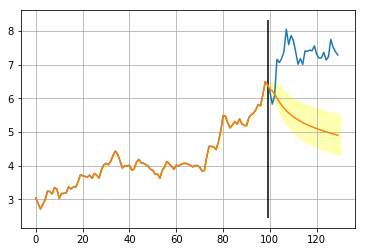

In [326]:
std = 1.96*np.sqrt(var).reshape(-1,)
x = np.linspace(0,ytest.shape[0],ytest.shape[0]).reshape(-1,)
ypred = ypred.reshape(-1,)

plt.plot(ytest)
plt.plot(ypred)
plt.fill_between(x,(ypred- std), (ypred+ std), color='yellow', alpha=.3, label='Cal SD')
plt.grid()
ymin, ymax = plt.ylim()
plt.vlines(days_back-1,ymin,ymax)

In [332]:
ypred[days_back-1:]

array([ 6.39999982,  6.26865621,  6.22710249,  6.12375591,  6.00582416,
        5.89471923,  5.79607244,  5.70976084,  5.63410817,  5.56729888,
        5.50776399,  5.45423346,  5.40569837,  5.36135759,  5.32057001,
        5.28281842,  5.24768038,  5.21480791,  5.18391107,  5.15474616,
        5.1271067 ,  5.10081599,  5.0757219 ,  5.05169287,  5.02861402,
        5.00638475,  4.98491662,  4.96413165,  4.94396076,  4.92434256,
        4.90522278])

In [337]:
pred_returns = (ypred[days_back-1:]/ypred[days_back-1])-1

In [341]:
pred_returns

array([ 0.        , -0.02052244, -0.02701521, -0.04316311, -0.06158995,
       -0.0789501 , -0.09436366, -0.10784984, -0.11967057, -0.13010953,
       -0.13941185, -0.147776  , -0.15535961, -0.16228785, -0.16866091,
       -0.1745596 , -0.18004992, -0.18518624, -0.19001387, -0.19457089,
       -0.19888956, -0.20299748, -0.20691843, -0.21067297, -0.21427904,
       -0.21775236, -0.22110676, -0.22435441, -0.22750611, -0.23057145,
       -0.23355892])

In [353]:
test = np.arange(1,pred_returns.shape[0])

In [378]:
rets = abs(pred_returns[1:]/test)

In [389]:
sqrt=var.flatten()[days_back:]

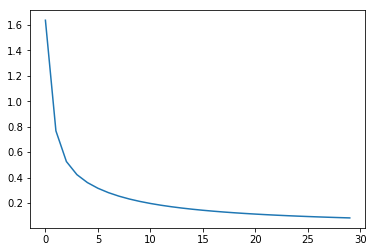

In [392]:
plt.plot(rets/sqrt)

In [336]:
ytest[days_back-1:].flatten()

array([ 6.4     ,  6.19125 ,  5.828125,  6.078125,  7.15625 ,  7.0625  ,
        7.18125 ,  7.3875  ,  8.05    ,  7.59375 ,  7.8625  ,  7.725   ,
        7.38125 ,  7.0125  ,  7.175   ,  7.00625 ,  7.40625 ,  7.39375 ,
        7.43125 ,  7.4125  ,  7.55625 ,  7.3     ,  7.19375 ,  7.2     ,
        7.3625  ,  7.1375  ,  7.23125 ,  7.75    ,  7.51875 ,  7.38125 ,
        7.2875  ])

Estimated intercept, slope: 0.263979, 2.965810


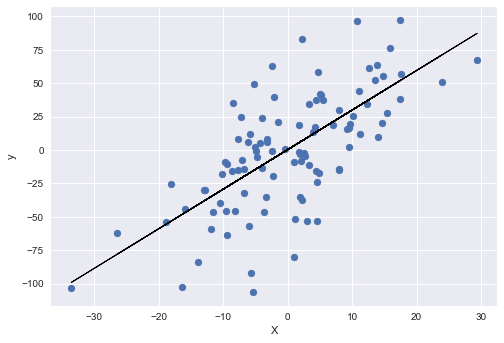

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn import linear_model



# Create N values, with 80% used for training 
# and 20% used for testing/evaluation
N = 500
split = int(0.8*N)

# Set the intercept and slope of the univariate
# linear regression simulated data
alpha = 2.0
beta = 3.0

# Set the mean and variance of the randomly
# distributed noise in the simulated dataset
eps_mu = 0.0
eps_sigma = 30.0

# Set the mean and variance of the X data
X_mu = 0.0
X_sigma = 10.0

# Create the error/noise, X and y data
eps = np.random.normal(loc=eps_mu, scale=eps_sigma, size=N)
X = np.random.normal(loc=X_mu, scale=X_sigma, size=N)
y = alpha + beta*X + eps
X = X.reshape(-1, 1)  # Needed to avoid deprecation warning

# Split up the features, X, and responses, y, into
# training and test arrays
X_train = X[:split]
X_test = X[split:]
y_train = y[:split]
y_test = y[split:]

# Open a scikit-learn linear regression model 
# and fit it to the training data
lr_model = linear_model.LinearRegression()
lr_model.fit(X_train, y_train)

# Output the estimated parameters for the linear model
print(
    "Estimated intercept, slope: %0.6f, %0.6f" % (
        lr_model.intercept_,
        lr_model.coef_[0]
    )
)

# Create a scatterplot of the test data for features
# against responses, plotting the estimated line
# of best fit from the ordinary least squares procedure
plt.scatter(X_test, y_test)
plt.plot(
    X_test, 
    lr_model.predict(X_test), 
    color='black',
    linewidth=1.0
)
plt.xlabel("X")
plt.ylabel("y")
plt.show()